# VISUAL TRANSFORMER MODEL FOR COVID/NON-COVID CLASSIFICATION

'''
@author: Ajay Arunachalam
'''

In [ ]:
from __future__ import print_function
import glob
from itertools import chain
import os
import random
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import math
from vit_pytorch.efficient import ViT
import cv2
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import requests

In [ ]:
os.getcwd()

In [ ]:
### Training settings

batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 142
IMG_SIZE = 224

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
seed_everything(seed)

In [ ]:
device = 'cpu'

In [ ]:
os.makedirs('lung_ct_scan_data', exist_ok=True)

In [ ]:
train_dir = 'lung_ct_scan_data/train'
test_dir = 'lung_ct_scan_data/test'

In [ ]:
train_list = glob.glob(os.path.join(train_dir,'*.png')) + glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.png')) + glob.glob(os.path.join(test_dir, '*.jpg'))

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

In [ ]:
labels = [path.split('\\')[-1].split(' (')[0] for path in train_list]

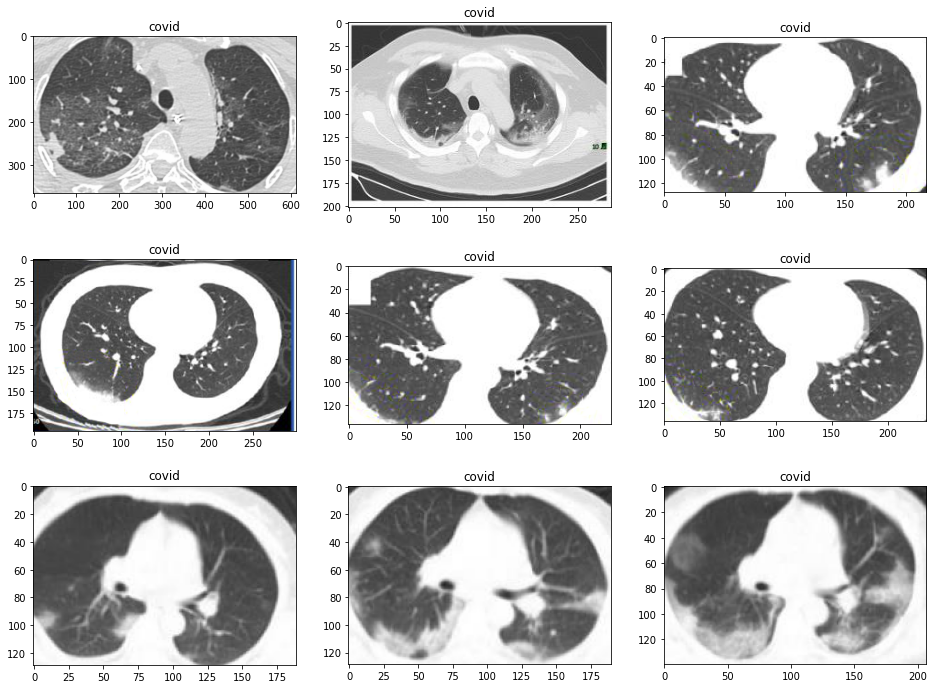

In [542]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [543]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [544]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 288
Validation Data: 72
Test Data: 386


### Image Augmentation

In [566]:
#Tune the transforms
ORIG_RES = False

if ORIG_RES:
    resize = 512
else:
    resize = 224

train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [547]:
train_transforms = transforms.Compose(
     [transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10, resample=Image.BILINEAR),
    transforms.RandomAffine(8, translate=(.15,.15)),
    transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transforms = transforms.Compose(
     [transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10, resample=Image.BILINEAR),
     transforms.RandomAffine(8, translate=(.15,.15)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transforms = transforms.Compose(
     [transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10, resample=Image.BILINEAR),
     transforms.RandomAffine(8, translate=(.15,.15)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

C:\Users\OruStandalone\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [567]:
class CovidNonCovidCTDataset(Dataset):
    def __init__(self, file_list, transform=None, orig_res=False):
        if orig_res:
            self.IMG_SIZE = 512
        else:
            self.IMG_SIZE = 224
        
        self.file_list = file_list
        self.transform = transform
        self.orig_res = orig_res
 
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img)

        label = img_path.split("\\")[-1].split(" (")[0]
        label = 1 if label == "covid" else 0

        return img_transformed, label

In [568]:
train_data = CovidNonCovidCTDataset(train_list, transform=train_transforms, orig_res = ORIG_RES)
valid_data = CovidNonCovidCTDataset(valid_list, transform=test_transforms, orig_res = ORIG_RES)
test_data = CovidNonCovidCTDataset(test_list, transform=test_transforms, orig_res = ORIG_RES)

In [569]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [570]:
print(len(train_data), len(train_loader))

288 5


In [571]:
print(len(valid_data), len(valid_loader))

72 2


In [572]:
efficient_transformer = Linformer(
    dim=128,#128
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [573]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
   channels=3,
).to(device)

In [574]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [575]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
        for data, label in valid_loader:
            
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7390 - acc: 0.5188 - val_loss : 0.7463 - val_acc: 0.3906



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.7273 - acc: 0.5000 - val_loss : 0.6964 - val_acc: 0.5547



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7056 - acc: 0.5000 - val_loss : 0.6833 - val_acc: 0.6094



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6973 - acc: 0.5031 - val_loss : 0.7010 - val_acc: 0.5000



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6982 - acc: 0.5031 - val_loss : 0.6949 - val_acc: 0.4453



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6972 - acc: 0.5063 - val_loss : 0.6942 - val_acc: 0.5000



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6912 - acc: 0.5125 - val_loss : 0.6914 - val_acc: 0.5703



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6911 - acc: 0.5250 - val_loss : 0.6927 - val_acc: 0.5000



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6892 - acc: 0.5000 - val_loss : 0.6850 - val_acc: 0.7109



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6899 - acc: 0.5656 - val_loss : 0.6928 - val_acc: 0.5000



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6877 - acc: 0.4969 - val_loss : 0.6937 - val_acc: 0.4297



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6879 - acc: 0.5375 - val_loss : 0.6915 - val_acc: 0.5547



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6853 - acc: 0.6562 - val_loss : 0.6831 - val_acc: 0.7500



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6856 - acc: 0.5781 - val_loss : 0.6919 - val_acc: 0.4844



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6864 - acc: 0.5906 - val_loss : 0.6929 - val_acc: 0.5859



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6834 - acc: 0.6687 - val_loss : 0.6875 - val_acc: 0.6406



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6809 - acc: 0.6062 - val_loss : 0.6891 - val_acc: 0.5312



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6816 - acc: 0.5531 - val_loss : 0.6778 - val_acc: 0.7578



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6783 - acc: 0.6594 - val_loss : 0.6771 - val_acc: 0.6250



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6789 - acc: 0.6156 - val_loss : 0.6869 - val_acc: 0.5703



In [576]:
# Save model
PATH = ".\ViTModel.pt" # Use your own path
torch.save(model.state_dict(), PATH)

In [589]:
# performance on test data

def test(model, test_loader, criterion):
    '''
    Model testing 
    
    Args:
        model: model used during training and validation
        test_loader: data loader object containing testing data
        criterion: loss function used
    
    Returns:
        test_loss: calculated loss during testing
        accuracy: calculated accuracy during testing
        y_proba: predicted class probabilities
        y_truth: ground truth of testing data
    '''
    
    y_proba = []
    y_truth = []
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(test_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        test_loss += criterion(output, y.long()).item()
        for index, i in enumerate(output):
            y_proba.append(i[1])
            y_truth.append(y[index])
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1
                
    accuracy = correct/total
    
    y_proba_out = np.array([float(y_proba[i]) for i in range(len(y_proba))])
    y_truth_out = np.array([float(y_truth[i]) for i in range(len(y_truth))])
    
    return test_loss, accuracy, y_proba_out, y_truth_out

In [590]:
loss, acc, y_proba, y_truth = test(model, test_loader, criterion = nn.CrossEntropyLoss())

  0%|          | 0/7 [00:00<?, ?it/s]

In [591]:
acc

0.5647668393782384

In [637]:
pd.value_counts(y_truth)

0.0    217
1.0    169
dtype: int64

In [ ]:
### LOAD SAVED MODEL
# =============================================================================
# model = ViT()
# model.load_state_dict(torch.load(PATH))
# model.eval()            
# =============================================================================

In [611]:
def display_FP_FN(model, test_loader, criterion, display = 'fp'):
    '''
    Displaying false positive or false negative images.
    
    Args:
        model: model used during training, testing and validation
        test_loader: data loader object for testing set
        criterion: loss function used
        display: either 'fp' for displaying false positives or 'fn' for false negatives
    
    Returns: void
    '''
    
    fp = []
    fn = []
    for data in tqdm(test_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        for index, i in enumerate(output):
            if torch.argmax(i.to(device)) == torch.Tensor([1]) and y[index].to(device) == torch.Tensor([0]):
                fp.append(X[index])
            elif torch.argmax(i.to(device)) == torch.Tensor([0]) and y[index].to(device) == torch.Tensor([1]):
                fn.append(X[index])
    
    fig = plt.figure()
    
    if display == 'fp':
        n_img = len(fp)
        cols = int(math.sqrt(n_img))
        for idx, img in enumerate(fp):
            a = fig.add_subplot(cols, np.ceil(n_img/float(cols)), idx + 1)
            plt.imshow(img.view(224, 224, 3).cpu())
            plt.axis('off')
    
            
    elif display == 'fn':
        n_img = len(fn)
        cols = int(math.sqrt(n_img))
        for idx, img in enumerate(fn):
            a = fig.add_subplot(cols, np.ceil(n_img/float(cols)), idx + 1)
            plt.imshow(img.view(224, 224, 3).cpu())
            plt.axis('off')

In [ ]:
display_FP_FN(model, test_loader, criterion = nn.CrossEntropyLoss(), display = 'fn')

In [639]:
def get_confusion_matrix(y_truth, y_proba, labels):# labels
    '''
    Displays confusion matrix given output and ground truth data.
    
    Args:
        y_truth: ground truth for testing data output
        y_proba: class probabilties predicted from model
        labels: a list of labels for each cell of confusion matrix
    
    Returns:
        cm: returns a numpy array representing the confusion matrix
        
    '''
    
    y_in = np.array([round(i) for i in y_proba])
    cm = confusion_matrix(y_truth, y_in, labels)#, labels
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('COVID Confusion Matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    return cm

C:\Users\OruStandalone\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\OruStandalone\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\OruStandalone\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


array([[213,   4],
       [149,  20]], dtype=int64)

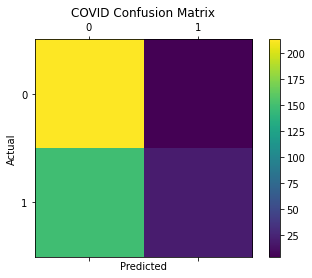

In [640]:
get_confusion_matrix(y_truth, y_proba, labels = [0, 1])#, labels = [0, 1]

In [619]:
def plot_ROCAUC_curve(y_truth, y_proba, fig_size):
    '''
    Plots the Receiver Operating Characteristic Curve (ROC) and displays Area Under the Curve (AUC) score.
    
    Args:
        y_truth: ground truth for testing data output
        y_proba: class probabilties predicted from model
        fig_size: size of the output pyplot figure
    
    Returns: void
    '''
    
    fpr, tpr, threshold = roc_curve(y_truth, y_proba)
    auc_score = roc_auc_score(y_truth, y_proba)
    txt_box = "AUC Score: " + str(round(auc_score, 4))
    plt.figure(figsize=fig_size)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'--')
    plt.annotate(txt_box, xy=(0.65, 0.05), xycoords='axes fraction')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")

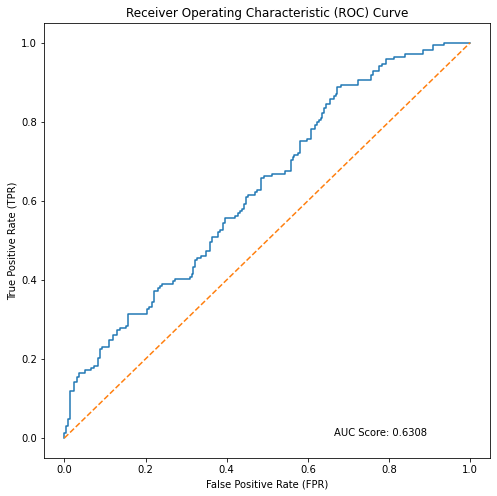

In [620]:
plot_ROCAUC_curve(y_truth, y_proba, (8, 8))